### 0. Download data set 

In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload()
# Chọn file kaggle.json tải về ở bước 2 để tải lên

!mkdir '/root/.kaggle'
!cp kaggle.json '/root/.kaggle'
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets list

Saving kaggle.json to kaggle.json
401 - Unauthorized


In [ ]:

!kaggle datasets download -d hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images

 87% 41.0M/47.0M [00:00<00:00, 111MB/s] 
100% 47.0M/47.0M [00:00<00:00, 109MB/s]


In [ ]:
!unzip -q /content/shoe-vs-sandal-vs-boot-dataset-15k-images.zip

### 1. Split Train Test

In [ ]:
path_training_set = '/content/Shoe vs Sandal vs Boot Dataset'

In [ ]:
path_train = '/content/dataset/train'
path_test = '/content/dataset/test'

In [ ]:
import os
import cv2

# load tung folder trong training_set
folders = os.listdir(path_training_set)

# tao thu muc label trong train va test
# chuyen den thu muc train
os.chdir(path_train)
for folder in folders:
    os.mkdir(folder)
# chuyen den thuc muc test
os.chdir(path_test)
for folder in folders:
    os.mkdir(folder)


In [ ]:
ff

Dang load: Boot
Dang load: Shoe
Dang load: Sandal


### 2. Visualize Data

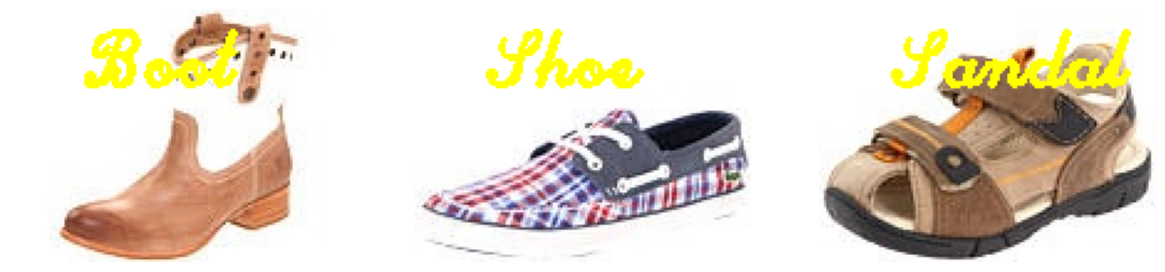

In [ ]:
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(20, 20))

i = 1
for folder in folders:
    images = os.listdir(f'{path_train}/{folder}')

    image = random.choice(images)

    img = cv2.imread(f'{path_train}/{folder}/{image}')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.putText(img, folder, (30, 30), cv2.FONT_HERSHEY_SCRIPT_COMPLEX, 1, (255, 255, 0), 2)

    plt.subplot(5, 4, i);plt.imshow(img);plt.axis('off')
    i = i + 1
    



### 3. Preparing Data

In [ ]:
import torch
from torchvision import datasets, transforms


# augment image
transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    # transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root=path_train, transform=transform, target_transform=None)
test_dataset = datasets.ImageFolder(root=path_test, transform=transform)


In [ ]:
class_name = train_dataset.classes
class_name

['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']

In [ ]:
NUM_WORKERS = os.cpu_count()
NUM_WORKERS

2

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_dataset, batch_size=32,shuffle=True)
test_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=False)

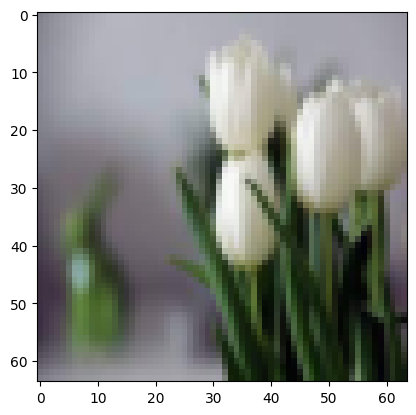

In [ ]:
img, label = next(iter(train_dataloader))
img[0].shape, label
plt.imshow(img[0].squeeze().permute(1, 2,0))

### 4. Building Model

In [ ]:
from torch import nn

# building model
class Model(nn.Module):
    def __init__(self, input_shape: int, out_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(input_shape, 16, 3),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(32, 64, 3),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*13*13, 512),
            nn.Linear(512, 64),
            nn.Linear(64, out_shape)
        )
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [ ]:
model = Model(3, len(class_name)).to(device)

In [ ]:
from prompt_toolkit.shortcuts.progress_bar.base import E
# show cnn use torchinfo
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model, input_size=[32, 3, 64, 64])

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [32, 5]                   --
├─Sequential: 1-1                        [32, 32, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 16, 62, 62]          448
│    └─ReLU: 2-2                         [32, 16, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 32, 60, 60]          4,640
│    └─ReLU: 2-4                         [32, 32, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 32, 30, 30]          --
├─Sequential: 1-2                        [32, 128, 13, 13]         --
│    └─Conv2d: 2-6                       [32, 64, 28, 28]          18,496
│    └─Conv2d: 2-7                       [32, 128, 26, 26]         73,856
│    └─ReLU: 2-8                         [32, 128, 26, 26]         --
│    └─MaxPool2d: 2-9                    [32, 128, 13, 13]         --
├─Sequential: 1-3                        [32, 5]                   --
│  

### 5. Training and Testing Loop

In [ ]:
# training
def train_step(model: torch.nn.Module,
               dataset: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
      # setup train loss, acc
      train_loss, train_acc = 0, 0

      # put model into mode train
      model.train()

      # loop
      for batch, (X, y) in enumerate(dataset):
          #send X, y to device
          X, y = X.to(device), y.to(device)

          # 1. Forward
          y_pred = model(X)

          # 2. calculate loss
          loss = loss_fn(y_pred, y)
          train_loss += loss.item()

          # 3. optimizer zero grad
          optimizer.zero_grad()

          # 4. backward
          loss.backward()

          # 5. update the optim
          optimizer.step()

          y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
          train_acc += ((y_pred_class == y).sum().item()) / len(y_pred)
      
      # adjust metric
      train_loss = train_loss / len(dataset)
      train_acc = train_acc / len(dataset)
      return train_loss, train_acc

In [ ]:
# testing
def test_step(model: torch.nn.Module,
              dataset: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module
              ):
  
    # setup test loss, acc
    test_loss, test_acc = 0, 0

    # put model into eval
    model.eval()

    # loop
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataset):
            # send X, y to device
            X, y = X.to(device), y.to(device)

            # 1. forward
            test_pred = model(X)

            # 2. calculate loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            test_pred_class = torch.argmax(torch.softmax(test_pred, dim = 1), dim=1)
            test_acc += ((test_pred_class == y).sum().item()) / len(test_pred)

        #adiust metric
        test_loss = test_loss / len(dataset)
        test_acc = test_acc / len(dataset)
        return test_loss, test_acc

In [ ]:
# ket hop train_step voi test_step
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int):

    # setup results
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

    torch.manual_seed(42)

    # loop
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model, dataset=train_dataloader, loss_fn=loss_fn, optimizer=optimizer)
        test_loss, test_acc = test_step(model=model, dataset=test_dataloader, loss_fn=loss_fn)

        print(f'Epoch: {epoch+1}')
        print(f'Train_loss: {train_loss:.4f}')
        print(f'Train_acc: {train_acc:.2f}')
        print(f'Test_loss: {test_loss:.4f}')
        print(f'Test_acc: {test_acc:.2f}')

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [ ]:
# training
epochs = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

model_results = train(model=model, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
                      loss_fn=loss_fn, optimizer=optimizer, epochs=epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train_loss: 1.3551
Train_acc: 0.42
Test_loss: 1.2243
Test_acc: 0.49
Epoch: 2
Train_loss: 1.1691
Train_acc: 0.53
Test_loss: 1.1213
Test_acc: 0.55
Epoch: 3
Train_loss: 1.0642
Train_acc: 0.57
Test_loss: 0.9827
Test_acc: 0.62
Epoch: 4
Train_loss: 1.0035
Train_acc: 0.61
Test_loss: 0.9065
Test_acc: 0.66
Epoch: 5
Train_loss: 0.8964
Train_acc: 0.65
Test_loss: 0.7512
Test_acc: 0.72


In [ ]:
# kiem tra
import torchvision
def pred_and_plot_img(model: torch.nn.Module,
                      image_path: str,
                      class_name: List[str] = None,
                      transform=None,
                      device: torch.device = device):
    # 1. load in image and convert
    target_img = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Devide the image pixel[0, 1]
    target_img = target_img / 255.

    # 3. transform
    if transform:
        target_image = transform(target_img)
    
    # 4. 
    model.to(device)
    
    # 5. turn on model
    model.eval()
    with torch.inference_mode():
        # them mot kic thuoc bo sung cho anh
        target_img = target_image.unsqueeze(dim=0)
        

        # make pred
        img_pred = model(target_img.to(device))
    
    # 6. convert logist
    img_pred_prob = torch.softmax(img_pred, dim=1)

    img_pred_class = torch.argmax(img_pred_prob, dim=1)

    # sap xep lai cac thu tu cua anh va show anh
    plt.imshow(target_img.squeeze().permute(1,2,0))
    if class_name:
        title = f'Pred: {class_name[img_pred_class.cpu()]} | Prob: {img_pred_prob.max().cpu():.2f}'
    else:
        title = f"Pred: {img_pred_class} | Prob: {img_pred_prob.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);


1


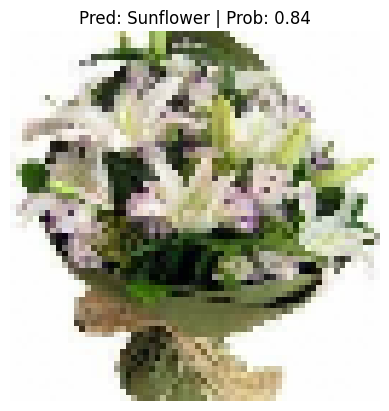

In [ ]:
# pred
path_img = '/content/dataset/test/Lilly/1000.jpg'
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])
pred_and_plot_img(model=model, image_path=path_img, class_name=class_name, transform=custom_image_transform, device=device)

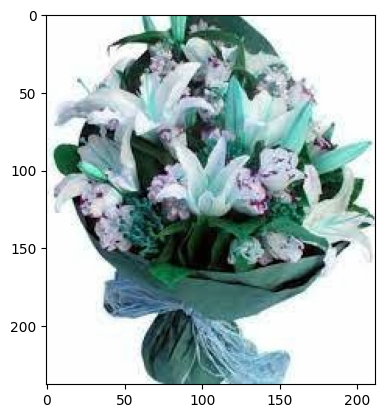

In [ ]:
image = cv2.imread(path_img)
plt.imshow(image)

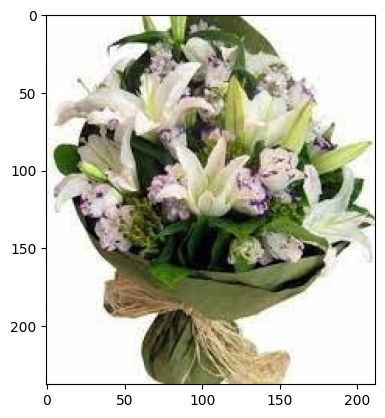

In [ ]:
img = torchvision.io.read_image(str(path_img)).type(torch.float32)
img = img/255.
plt.imshow(img.squeeze().permute(1,2,0))

In [ ]:
for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)
    print(batch)
    print(X.shape)
    print(y)
    
    y_pred = model(X)
    print(torch.softmax(y_pred, dim=1))
    print(torch.argmax(torch.softmax(y_pred, dim = 1), dim=1))
    break

0
torch.Size([32, 3, 64, 64])
tensor([2, 0, 0, 2, 2, 1, 1, 0, 1, 0, 2, 1, 2, 0, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 2, 0, 1, 2, 0], device='cuda:0')
tensor([[0.3189, 0.3383, 0.3428],
        [0.3189, 0.3378, 0.3432],
        [0.3190, 0.3382, 0.3428],
        [0.3185, 0.3383, 0.3432],
        [0.3191, 0.3381, 0.3429],
        [0.3188, 0.3382, 0.3430],
        [0.3196, 0.3376, 0.3429],
        [0.3183, 0.3383, 0.3433],
        [0.3191, 0.3375, 0.3434],
        [0.3192, 0.3380, 0.3427],
        [0.3191, 0.3387, 0.3423],
        [0.3198, 0.3380, 0.3422],
        [0.3194, 0.3384, 0.3422],
        [0.3192, 0.3385, 0.3423],
        [0.3189, 0.3383, 0.3429],
        [0.3190, 0.3385, 0.3425],
        [0.3191, 0.3379, 0.3429],
        [0.3199, 0.3379, 0.3422],
        [0.3186, 0.3386, 0.3428],
        [0.3182, 0.3382, 0.3436],
        [0.3187, 0.3383, 0.3431],
        [0.3183, 0.3376, 0.3441],
        [0.3186, 0.3384, 0.3430],
        [0.3194, 0.3380, 0.3425],
        [0.3183, 0.3383,

In [ ]:
model_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

### 6. Plot

In [ ]:
# plot
from typing import Tuple, Dict, List
def plot_loss_acc(results: Dict[str, List[float]]):

    # get the loss
    train_loss = results['train_loss']
    test_loss = results['test_loss']

    # get the acc
    train_acc = results['train_acc']
    test_acc = results['test_acc']

    epochs = range(len(results['train_loss']))

    # setup figure
    plt.figure(figsize=(15, 7))

    # plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # plot acc
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='train_acc')
    plt.plot(epochs, test_acc, label='test_acc')
    plt.title('Acc')
    plt.xlabel('Epochs')
    plt.legend();

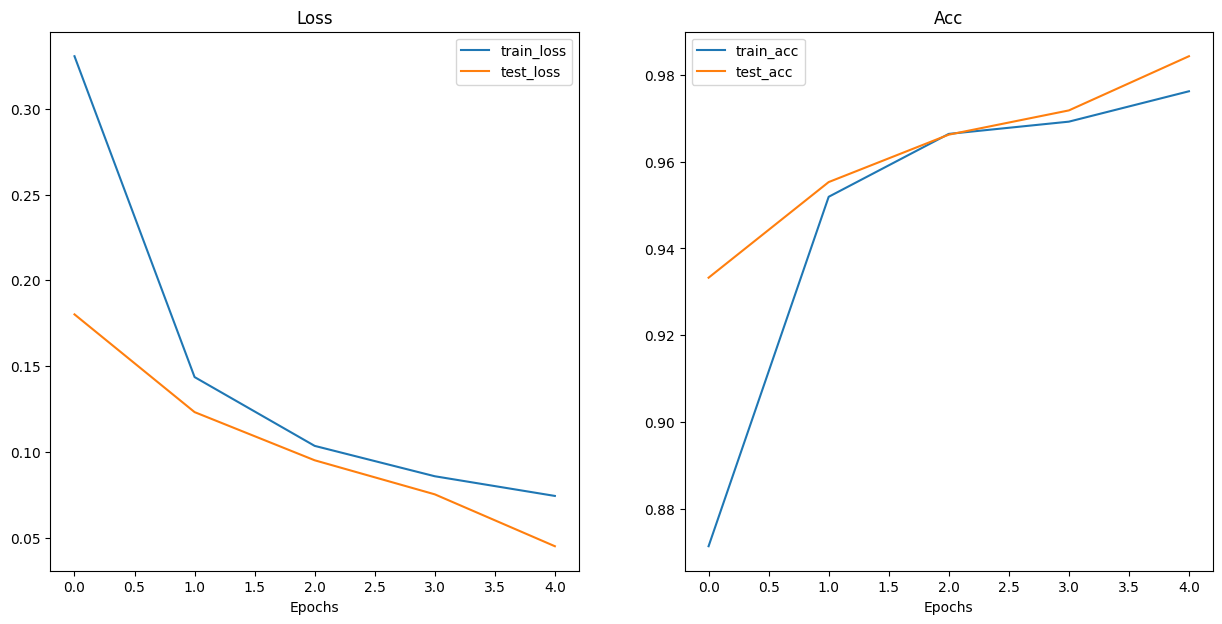

In [ ]:
plot_loss_acc(model_results)